In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
torch.set_default_dtype(torch.float32)

In [2]:
def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']
        
    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.
    
    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1
    
    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (torch.tensor(x_train,dtype=torch.float32), torch.tensor(y_train,dtype=torch.float32)), (torch.tensor(x_test,dtype=torch.float32), torch.tensor(y_test,dtype=torch.float32))

In [3]:
class Encoder(nn.Module):
    def __init__(self,sizes) -> None:
        super().__init__()
        self.latent_size=sizes[-1]
        self.network=[]
        for i in range(len(sizes)-2):
            self.network.append(nn.Linear(sizes[i],sizes[i+1]))
            self.network.append(nn.ReLU())
        self.encode_mu=nn.Linear(sizes[-2],sizes[-1])
        self.encode_sigma=nn.Linear(sizes[-2],sizes[-1])
        self.network=nn.Sequential(*self.network)

    def forward(self,x):
        x=self.network(x)
        mu=self.encode_mu(x)
        sigma=torch.exp(self.encode_sigma(x))
        return mu,sigma



class Decoder(nn.Module):
    def __init__(self,sizes) -> None:
        super().__init__()
        self.network=[]
        for i in range(len(sizes)-2):
            self.network.append(nn.Linear(sizes[i],sizes[i+1]))
            self.network.append(nn.ReLU())
        self.network.append(nn.Linear(sizes[-2],sizes[-1]))
        self.network=nn.Sequential(*self.network)

    def forward(self,x):
        return torch.sigmoid(self.network(x))

class VAE_torch(nn.Module):
    def __init__(self,encoder, decoder,latent_size) -> None:
        super().__init__()
        self.latent_size=latent_size
        self.encoder=encoder
        self.decoder=decoder
    
    def forward(self,x):
        mu,sigma=self.encoder(x)
        eps=torch.normal(0,1,(mu.shape[0],self.latent_size))
        sampled_vector=mu+eps*sigma
        return self.decoder(sampled_vector),mu,sigma

    def sample(self,x,epsilon=0.0):
        mu,sigma=self.encoder(x)
        sampled_vector=torch.zeros(x.shape[0],self.latent_size)
        for j in range(mu.shape[0]):
            sampled_vector[j,:]=torch.distributions.Normal(mu[j],sigma[j]).sample()
        print(sampled_vector)
        return self.decoder(sampled_vector)


def KL(mean,sigma):
    return 0.5*torch.sum((torch.sum(sigma.pow(2),dim=1)+torch.sum(mean.pow(2),dim=1)-torch.sum(torch.log(sigma.pow(2)),dim=1)-1))

def ELBO(values,pred_values,mean,sigma,beta=1):
    return (nn.functional.binary_cross_entropy(pred_values, values,reduction="sum")+beta*KL(mean,sigma))/values.shape[0]

def visualize(res1,VAE):
    new=VAE.sample(res1.expand(5,784))
    f,axes=plt.subplots(2,3,figsize=(21,14))
    ax=axes.flatten()[0]
    ax.imshow(res1.reshape(28,28),cmap="viridis_r")
    ax.set_title("Original image")
    for spine in ax.spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(4)
    for j in range(5):
        ax=axes.flatten()[j+1]
        ax.imshow(new[j,:].detach().numpy().reshape(28,28),cmap="viridis_r")
    plt.tight_layout()

In [4]:
(xtrain,ytrain),(xtest,ytest)=load_mnist()

In [5]:
num_epoch=40    
batch=100
VAE=VAE_torch(Encoder([784,110,30,10]),Decoder([10,30,110,784]),10)
optim=torch.optim.Adam(VAE.parameters(),lr=0.003)
beta=1
err_train=[]
err_test=[]
for i in range(num_epoch):
    for j in range(0,60000,batch):
        xbatch=xtrain[j:j+batch]
        optim.zero_grad()
        results,mean,sigma=VAE(xbatch)
        loss=ELBO(xbatch,results,mean,sigma,beta=beta)
        loss.backward()
        optim.step()
    with torch.no_grad():
        test_res,mean,sigma=VAE(xtest)
        loss_test=ELBO(xtest,test_res,mean,sigma,beta=beta)
        print("Epoche: ",i,"loss train: {:.3f}".format(loss.item()),"loss test: {:.3f}".format(loss_test.item()))
        err_train.append(loss.item())
        err_test.append(loss_test.item())

Epoche:  0 loss train: 174.450 loss test: 164.516
Epoche:  1 loss train: 150.143 loss test: 145.924
Epoche:  2 loss train: 141.772 loss test: 142.706
Epoche:  3 loss train: 138.677 loss test: 142.509
Epoche:  4 loss train: 136.043 loss test: 138.245
Epoche:  5 loss train: 134.021 loss test: 135.318
Epoche:  6 loss train: 131.343 loss test: 131.937
Epoche:  7 loss train: 129.951 loss test: 130.559
Epoche:  8 loss train: 129.589 loss test: 129.967
Epoche:  9 loss train: 127.524 loss test: 128.655
Epoche:  10 loss train: 128.494 loss test: 129.452
Epoche:  11 loss train: 127.543 loss test: 128.800
Epoche:  12 loss train: 127.702 loss test: 128.635
Epoche:  13 loss train: 128.472 loss test: 128.344
Epoche:  14 loss train: 126.566 loss test: 128.247
Epoche:  15 loss train: 127.430 loss test: 128.529
Epoche:  16 loss train: 127.122 loss test: 127.949
Epoche:  17 loss train: 125.606 loss test: 127.570
Epoche:  18 loss train: 126.223 loss test: 127.133
Epoche:  19 loss train: 126.612 loss test

Text(0.5, 0, 'epoche number')

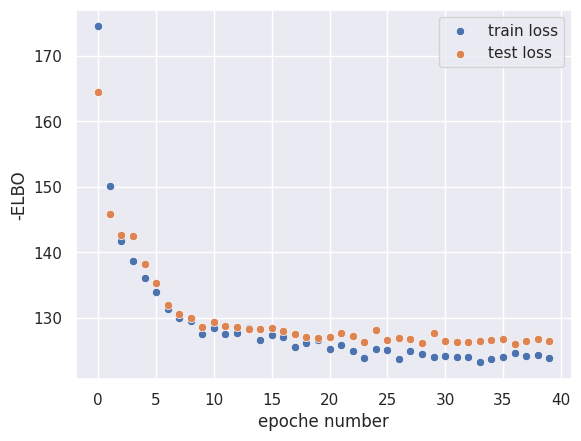

In [6]:
sns.scatterplot(x=np.arange(0,len(err_train)),y=err_train,label="train loss")
sns.scatterplot(x=np.arange(0,len(err_test)),y=err_test,label="test loss")
plt.ylabel(r"-ELBO")
plt.xlabel("epoche number")

tensor([[-1.2074, -0.3724, -0.6873, -0.1424, -0.7559, -0.9048, -0.1998, -1.8273,
         -0.0705,  0.6965],
        [-1.0720, -0.4861, -0.1683, -0.3593, -0.6108,  1.7783, -0.2072, -2.2394,
          0.1374,  1.3912],
        [-1.1636, -0.4445, -0.1851, -0.0603, -0.7471, -0.4048, -0.6598, -2.1036,
         -0.1331,  1.4226],
        [-1.1101, -0.3518,  0.0080,  0.0241, -0.6540,  2.4689, -0.2756, -1.7582,
         -0.6907,  0.9059],
        [-1.1787, -0.4652, -1.1451, -0.1549, -0.5589, -1.6495, -0.2182, -1.9877,
         -0.2256, -0.4894]])


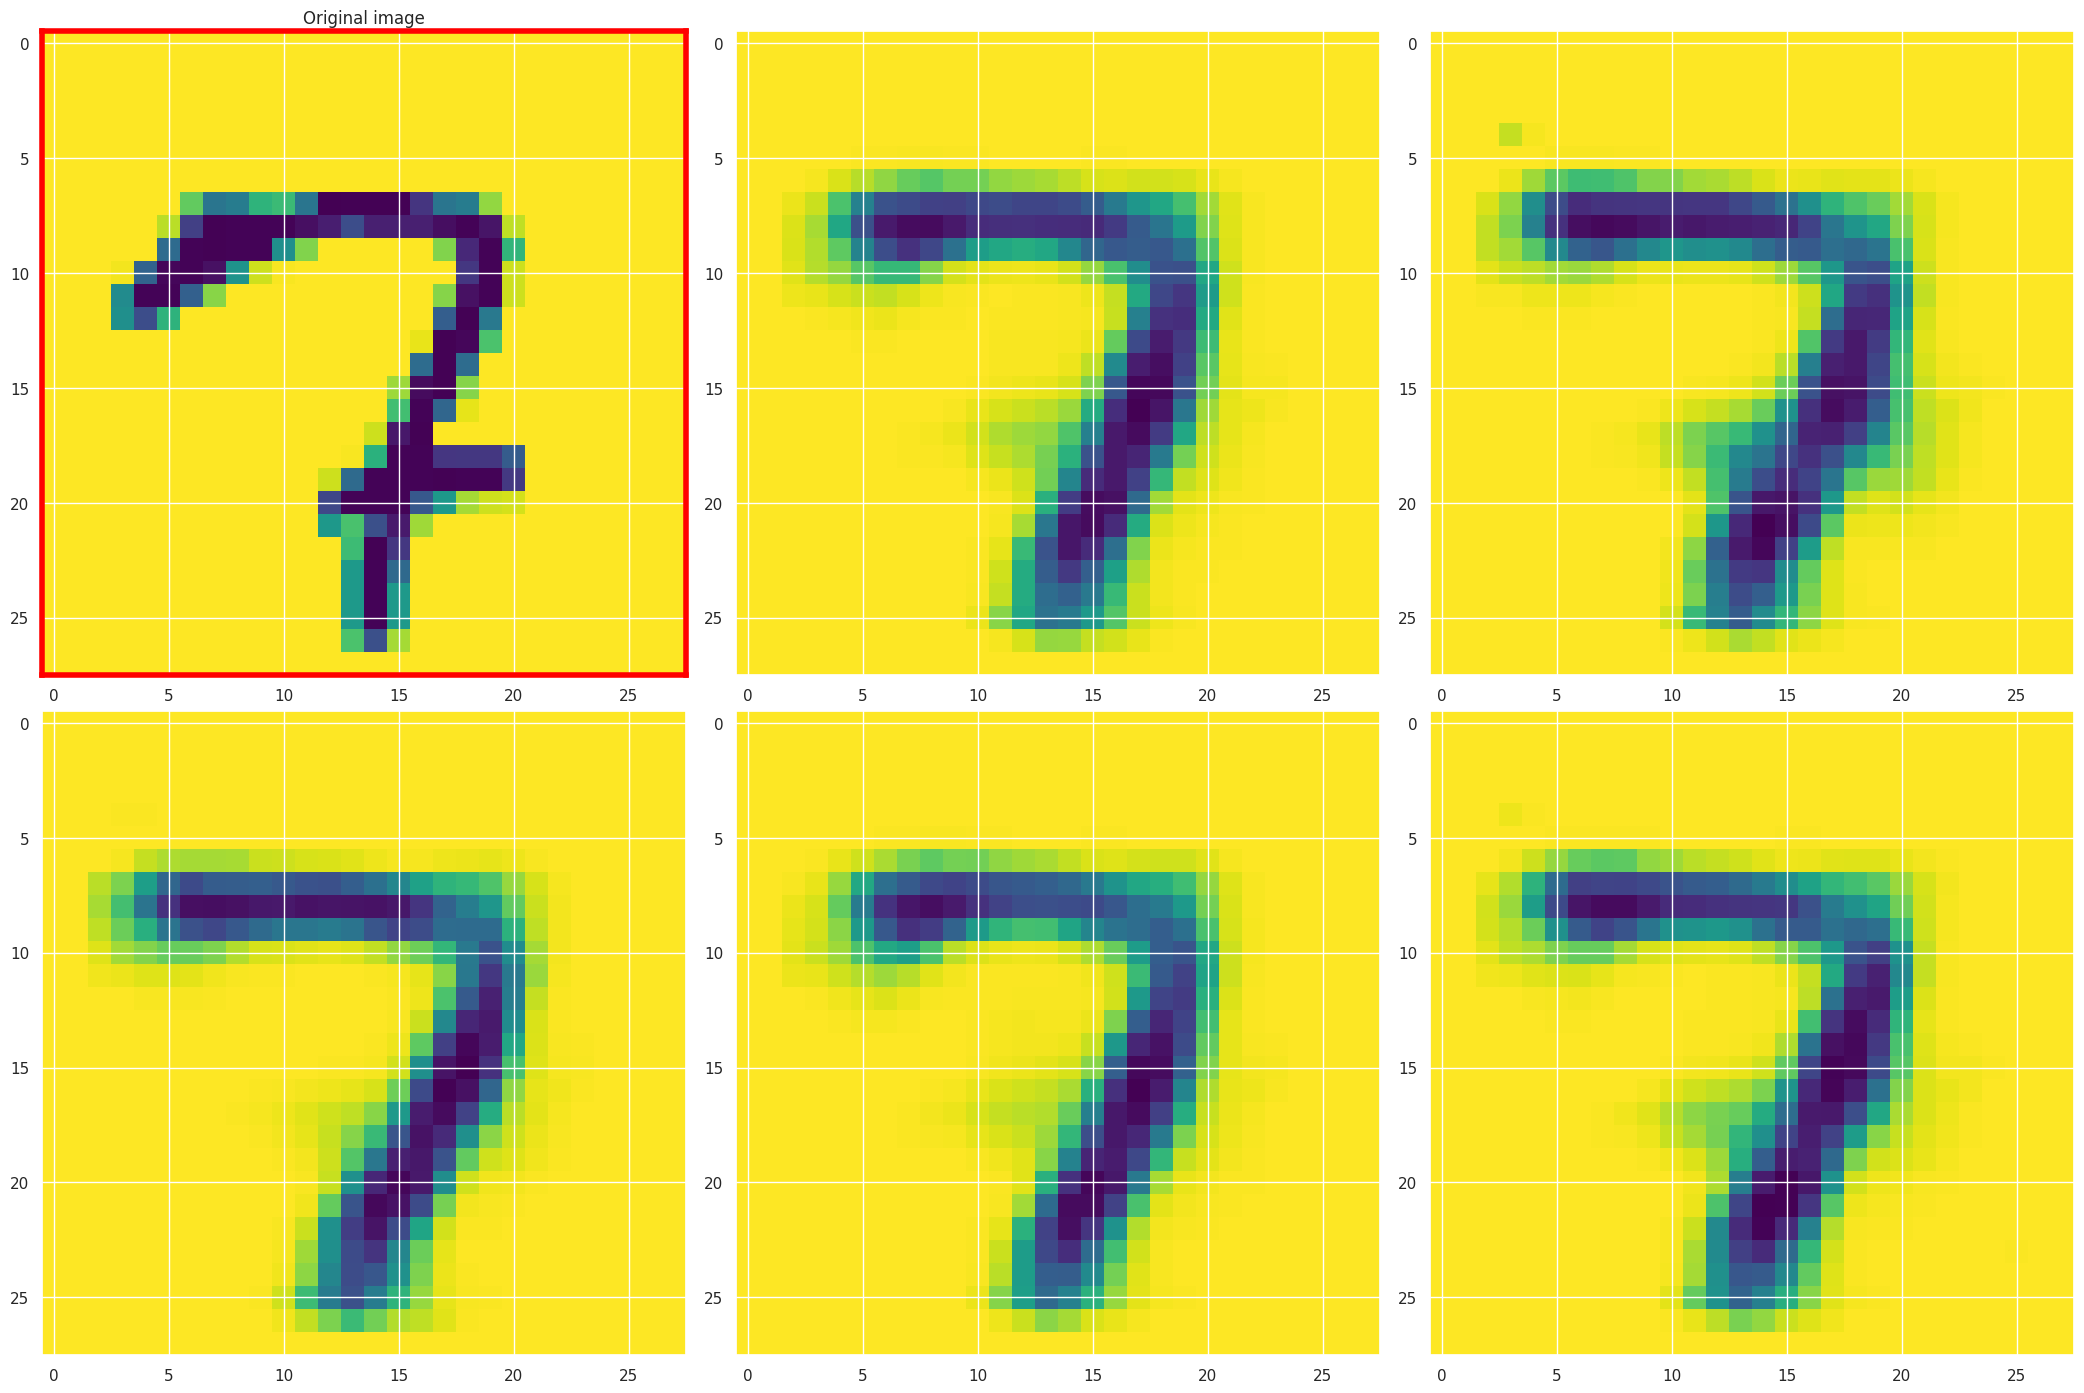

In [7]:
n=36
visualize(xtest[n],VAE)